In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc

# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

(CVXPY) Mar 27 11:48:06 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 27 11:48:06 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Cargamos los datos 
dt=pd.read_excel('DatosPractica_Scoring.xlsx')

In [3]:
dt.drop(labels='ID',inplace=True, axis=1)
dt.drop(labels='Exp_Inc',inplace=True, axis=1)
dt.drop(labels='Avgexp',inplace=True, axis=1)


In [4]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cardhldr  1285 non-null   float64
 1   default   994 non-null    float64
 2   Age       1319 non-null   float64
 3   Income    1319 non-null   float64
 4   Ownrent   1319 non-null   int64  
 5   Selfempl  1319 non-null   int64  
 6   Depndt    1319 non-null   int64  
 7   Inc_per   1319 non-null   float64
 8   Cur_add   1319 non-null   int64  
 9   Major     1319 non-null   int64  
 10  Active    1319 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 113.5 KB


In [5]:
# Variable objetivo: default

dt['default'].value_counts()

default
0.0    890
1.0    104
Name: count, dtype: int64

In [6]:
# Lista de columnas con menos de 10 valores distintos. Potenciales factores!
to_factor = list(dt.loc[:,dt.nunique() <= 10]);  

# loc utiliza columnas, por filas todas, 
# Podemos cambiar el tipo de todas ellas a factor de una vez
dt[to_factor] = dt[to_factor].astype('category')

In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Cardhldr  1285 non-null   category
 1   default   994 non-null    category
 2   Age       1319 non-null   float64 
 3   Income    1319 non-null   float64 
 4   Ownrent   1319 non-null   category
 5   Selfempl  1319 non-null   category
 6   Depndt    1319 non-null   category
 7   Inc_per   1319 non-null   float64 
 8   Cur_add   1319 non-null   int64   
 9   Major     1319 non-null   category
 10  Active    1319 non-null   int64   
dtypes: category(6), float64(3), int64(2)
memory usage: 60.3 KB


In [8]:
dt['default'] =dt['default'].astype(float)

## Rectificamos la variable Edad

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


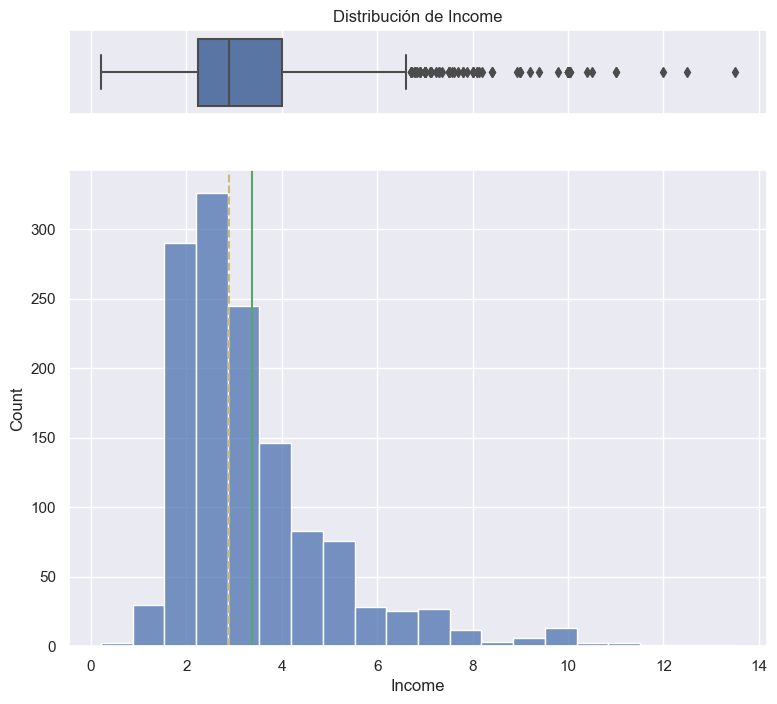

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='g',linestyle='-')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data),color='y',linestyle='--')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title, xlabel="")
    # Mostrar gráfico
    plt.show()

histogram_boxplot(dt['Income'], bins = 20, font_scale=1, title="Distribución de Income")

In [10]:
# Hacemos una tabla de frecuencia
dt.Income.value_counts()

Income
3.0000    61
2.5000    46
2.0000    44
3.5000    41
4.0000    32
          ..
5.1600     1
3.6208     1
2.3779     1
2.8055     1
1.5150     1
Name: count, Length: 431, dtype: int64

In [11]:
dt.select_dtypes(include=np.number).apply(lambda x: x.skew())

default    2.587421
Age        0.841428
Income     1.928085
Inc_per    1.990676
Cur_add    2.570304
Active     1.213365
dtype: float64

In [12]:
## Función manual de winsor con clip+quantile 
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

# clip --> hacer el colapso en cierto percentil

In [13]:
from scipy import stats # Añadimos en este punto para cargar la librería que ahora hace falta

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6 ## Cambio mad por median_abs_deviation!! 
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

          
# Llamada en modo check
dt.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))#.set_index(['Low','up','Tot'])

default
Age
Income
Inc_per
Cur_add
Active


,default,Age,Income,Inc_per,Cur_add,Active
0,0.0,0.000000,0.000000,0.00000,0.000000,0.00000
1,0.0,0.075815,1.592115,0.90978,1.743745,0.15163
2,0.0,0.075815,1.592115,0.90978,1.743745,0.15163


In [14]:
# Crear copia para evitar pisar información
dtCont = dt.select_dtypes(include=np.number).copy()

# Aplicar la gestión de outliers en modelo winsor
dt_winsor = dtCont.apply(lambda x: gestiona_outliers(x,clas='winsor'))

# Contemos si ha desaparecido algún resgitro o algo 
dt_winsor.apply(lambda x: x.isna().sum()/x.count()*100)

default
Age
Income
Inc_per
Cur_add
Active


default    32.696177
Age         0.000000
Income      0.000000
Inc_per     0.000000
Cur_add     0.000000
Active      0.000000
dtype: float64

In [15]:
dt_winsor.describe()

,default,Age,Income,Inc_per,Cur_add,Active
count,994.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.104628,33.213103,3.348123,2.142413,53.864291,6.995451
std,0.306227,10.142783,1.620624,1.298667,59.709099,6.296660
min,0.000000,0.166667,0.210000,0.070000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,1.200000,12.000000,2.000000
50%,0.000000,31.250000,2.900000,1.875000,30.000000,6.000000
75%,0.000000,39.416670,4.000000,2.700000,72.000000,11.000000
max,1.000000,83.500000,9.400000,7.350000,264.000000,44.000000


In [16]:
dt_wins = dt_winsor.join(dt.select_dtypes(exclude=np.number))
dt_wins.head(5)


,default,Age,Income,Inc_per,Cur_add,Active,Cardhldr,Ownrent,Selfempl,Depndt,Major
0,0.0,27.08333,2.400,2.400000,56,1,1.0,0,0,0,1
1,1.0,24.25000,3.500,3.500000,60,11,1.0,0,0,0,1
2,NaN,27.41667,1.600,0.800000,30,0,0.0,1,0,1,0
3,0.0,40.33333,3.067,1.022333,18,0,1.0,0,0,2,0
4,0.0,28.16667,3.350,3.350000,18,2,1.0,1,0,0,1


### Análisis univariante y de asociación con las variable objetivo de las variables categóricas

### Own rent

In [17]:

dt_wins['Ownrent'].value_counts(normalize=True,dropna=False).sort_index()

Ownrent
0    0.559515
1    0.440485
Name: proportion, dtype: float64

In [18]:
ctabla=pd.crosstab(dt_wins['Ownrent'],dt_wins['default'],margins=True).round(3)
ctabla

default,0.0,1.0,All
Ownrent,,,
0,468,49,517
1,422,55,477
All,890,104,994


c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


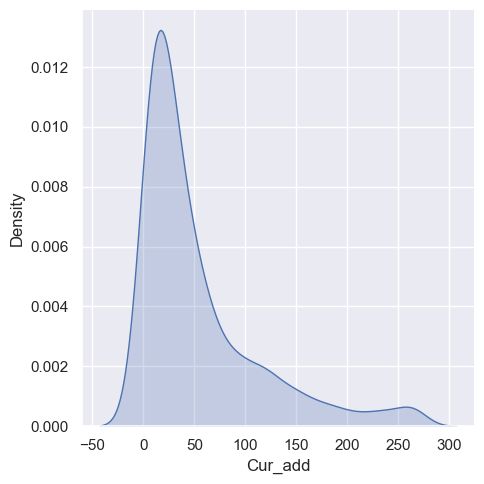

In [53]:
sns.displot((dt_wins['Cur_add']), kind="kde", fill=True)
plt.show()

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


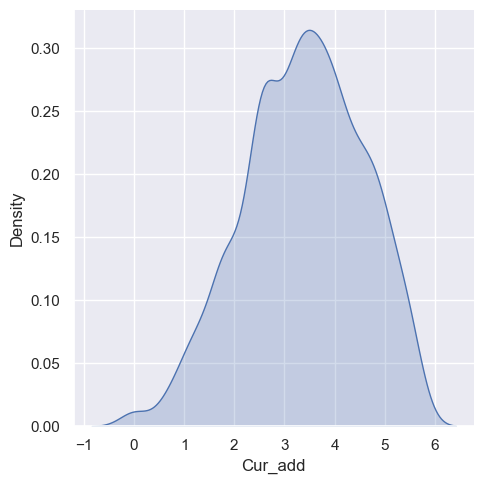

In [54]:
sns.displot(np.log(dt_wins['Cur_add']), kind="kde", fill=True)
plt.show()

In [21]:
dt_wins['Income'] =np.log(dt_wins['Income']).round(5)



In [22]:
dt_wins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   default   994 non-null    float64 
 1   Age       1319 non-null   float64 
 2   Income    1319 non-null   float64 
 3   Inc_per   1319 non-null   float64 
 4   Cur_add   1319 non-null   int64   
 5   Active    1319 non-null   int64   
 6   Cardhldr  1285 non-null   category
 7   Ownrent   1319 non-null   category
 8   Selfempl  1319 non-null   category
 9   Depndt    1319 non-null   category
 10  Major     1319 non-null   category
dtypes: category(5), float64(4), int64(2)
memory usage: 69.2 KB


In [23]:
dt_acept = dt_wins.copy()
dt_acept = dt_acept[dt_acept['Cardhldr'] == 1]


In [24]:
dt_acept['default'].value_counts(normalize=True)

default
0.0    0.895372
1.0    0.104628
Name: proportion, dtype: float64

In [25]:
dt_train, dt_test = train_test_split(dt_acept,stratify=dt_acept["default"], test_size=.25, random_state=1234)

In [26]:
dt_train["default"].mean().round(2)

0.1

In [27]:
dt_test["default"].mean().round(2)

0.1

In [85]:
# Definimos la tramificación óptima
# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "gini": {"min": 0.15} # no aplicamos "max": 1}
}

# En caso de que desee modificarse los val ores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario
binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

### Este es el resultado de esta primera parte de tramificación y selección de variables explicativas 
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
7,Selfempl,categorical,OPTIMAL,False,2,0.000814,0.000102,0.006716,0.000127
9,Major,categorical,OPTIMAL,False,2,0.005159,0.000644,0.026709,0.004668
6,Ownrent,categorical,OPTIMAL,False,2,0.029604,0.003696,0.085699,0.076082
8,Depndt,categorical,OPTIMAL,False,4,0.05009,0.006212,0.109466,0.02839
2,Inc_per,numerical,OPTIMAL,True,9,0.185743,0.022645,0.232906,0.006934
1,Income,numerical,OPTIMAL,True,4,0.284812,0.031672,0.192732,0.419345
0,Age,numerical,OPTIMAL,True,7,0.329546,0.038468,0.285969,0.06424
3,Cur_add,numerical,OPTIMAL,True,6,0.340545,0.041078,0.287308,0.020475
5,Cardhldr,categorical,OPTIMAL,True,2,0.343565,0.041876,0.264957,0.448022
4,Active,numerical,OPTIMAL,True,7,1.206197,0.123028,0.493615,0.006716


In [29]:
# Estimamos el modelo con la regresión logística directamente con el método que incorpora directamente el objeto Scorecard

estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

# El resultado del modelo se ha estimado en este objeto `tarjeta`, que podría inspeccionar 
# tarjeta.information(print_level=2)
# tarjeta.table(style="detailed") (aquí proporciona también los coeficientes estimados)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Cardhldr',
                                                                'Ownrent',
                                                                'Selfempl',
                                                                'Depndt',
                                                                'Major'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Inc_per', 'Cur_add',
                                                         'Active', 'Cardhldr',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Major']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [87]:
# obtenmos las predicciones de probabilidad
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.14954

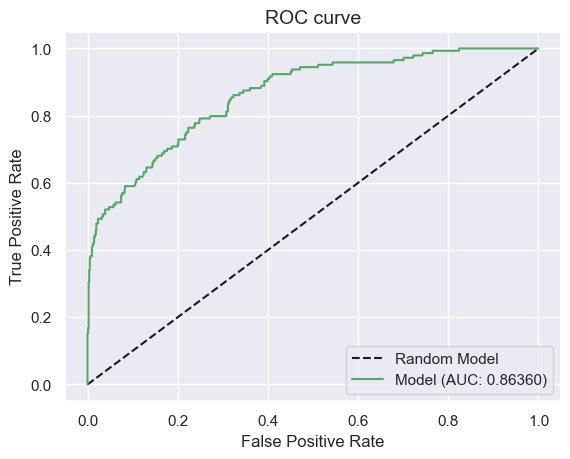

In [88]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

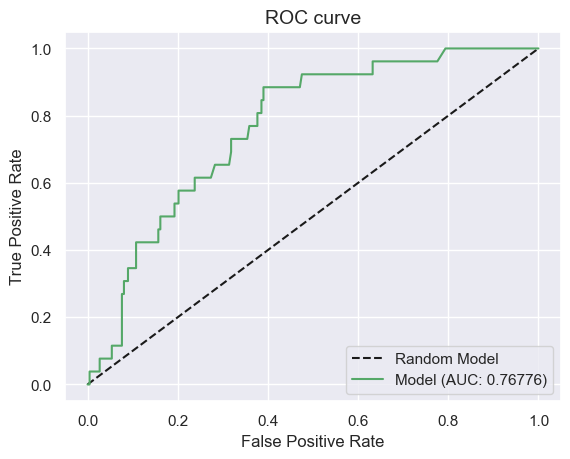

In [32]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la variable y
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

### Realizamos la inferencia de rechazados

A partir de este primer modelo realizamos una predicción

In [89]:
# primero estimo el **punto de corte de la probabilidad utilizando el valor medio**. Ese punto de corte es el que me va a clasificar a los clientes como de malos Prob Estimada > Prob_corte.
Prob_Corte=Y.mean()
print(Prob_Corte)


0.14953271028037382


In [34]:
Rechazados = dt_wins.copy()
Rechazados = Rechazados[Rechazados['Cardhldr'] == 0]

In [90]:
# Hacemos la inferencia de rechazados
# Necesitamos puntuar a los rechazados con el modelo estimado sólo con los aceptados

X_rechazados = Rechazados #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
Rechazados["default"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)

In [91]:
print(Rechazados["default"].value_counts(normalize=True))

default
1    0.553265
0    0.446735
Name: proportion, dtype: float64


In [92]:


Nuevos = dt_wins.copy()

# Filtrar Nuevos1 para seleccionar solo las filas donde el valor en la columna 'Cardhldr' no sea ni 1 ni 0
Nuevos = Nuevos[~((Nuevos['Cardhldr'] == 1) | (Nuevos['Cardhldr'] == 0))]

In [93]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = Nuevos#todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Sinrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

In [94]:
print(Nuevos["y_Sinrechazados"].value_counts(normalize=True))

y_Sinrechazados
1    0.529412
0    0.470588
Name: proportion, dtype: float64


In [95]:
dt1=pd.concat([dt_acept,Rechazados], axis=0)

In [41]:
dt1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 0 to 1281
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   default   1285 non-null   float64 
 1   Age       1285 non-null   float64 
 2   Income    1285 non-null   float64 
 3   Inc_per   1285 non-null   float64 
 4   Cur_add   1285 non-null   int64   
 5   Active    1285 non-null   int64   
 6   Cardhldr  1285 non-null   category
 7   Ownrent   1285 non-null   category
 8   Selfempl  1285 non-null   category
 9   Depndt    1285 non-null   category
 10  Major     1285 non-null   category
dtypes: category(5), float64(4), int64(2)
memory usage: 77.4 KB


In [42]:
dt1['default'].value_counts()

default
0.0    1093
1.0     192
Name: count, dtype: int64

In [43]:
dt1['default'].value_counts(normalize=True)

default
0.0    0.850584
1.0    0.149416
Name: proportion, dtype: float64

In [105]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt1,stratify=dt1["default"], test_size=.25, random_state=1234)
print(dt_train["default"].mean(),dt_test["default"].mean())
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02} #, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

0.2066458982346833 0.20496894409937888


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Ownrent,categorical,OPTIMAL,False,2,0.000252,0.000032,0.007867,0.000109
9,Major,categorical,OPTIMAL,False,2,0.00075,0.000094,0.010537,0.00033
8,Depndt,categorical,OPTIMAL,False,4,0.014562,0.001816,0.056,0.001132
7,Selfempl,categorical,OPTIMAL,True,2,0.022392,0.002767,0.038096,0.013437
1,Income,numerical,OPTIMAL,True,5,0.066607,0.008114,0.096832,0.036918
2,Inc_per,numerical,OPTIMAL,True,8,0.101027,0.011917,0.136579,0.00002
0,Age,numerical,OPTIMAL,True,8,0.230931,0.027589,0.239009,0.001611
3,Cur_add,numerical,OPTIMAL,True,6,0.346288,0.041117,0.309111,0.654824
4,Active,numerical,OPTIMAL,True,8,0.933752,0.094674,0.393367,0.003679
5,Cardhldr,categorical,OPTIMAL,True,2,1.270895,0.14708,0.50882,0.014382


In [106]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Cardhldr',
                                                                'Ownrent',
                                                                'Selfempl',
                                                                'Depndt',
                                                                'Major'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Inc_per', 'Cur_add',
                                                         'Active', 'Cardhldr',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Major']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [107]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.20663

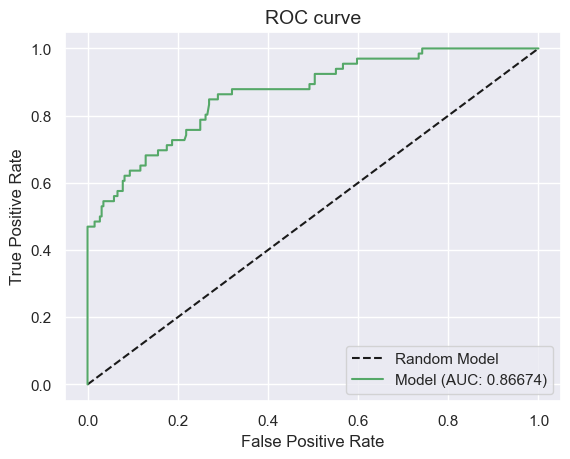

In [108]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

In [109]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
print(Prob_Corte)
print(f1_score(Y,Y_pred>Prob_Corte))

# Hacemos la inferencia

X_Nuevos = Nuevos.drop(columns=['y_Sinrechazados']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Conrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

0.2066458982346833
0.6651884700665188


In [110]:

print("\n Prob SIN Rechazados Real: \n",Nuevos["Prob_Sinrechazados"].mean())
print("\n Prob CON Rechazados: \n",Nuevos["Prob_Conrechazados"].mean())


 Prob SIN Rechazados Real: 
 0.14328289457666352

 Prob CON Rechazados: 
 0.25185234502561177


In [111]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print("Puntuación mínima: ", score.min().round(2))
print("Puntuación máxima: ",score.max().round(2))
print("Puntuación media : ",score.mean().round(2))  


# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

#Podríamos haber calculado la puntuación también manualmente
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

# Podemos comprobar que los resultados son los mismos   
print("Puntuación mínima: ",score2.min().round(2))
print("Puntuación máxima: ",score2.max().round(2))
print("Puntuación media : ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

Puntuación mínima:  168.61
Puntuación máxima:  1008.6
Puntuación media :  514.8
Puntuación mínima:  168.61
Puntuación máxima:  1008.6
Puntuación media :  514.8


In [112]:

Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )


La probabilida de corte de:  0.2066458982346833  equivale a una puntuación de corte de:  451.88


c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


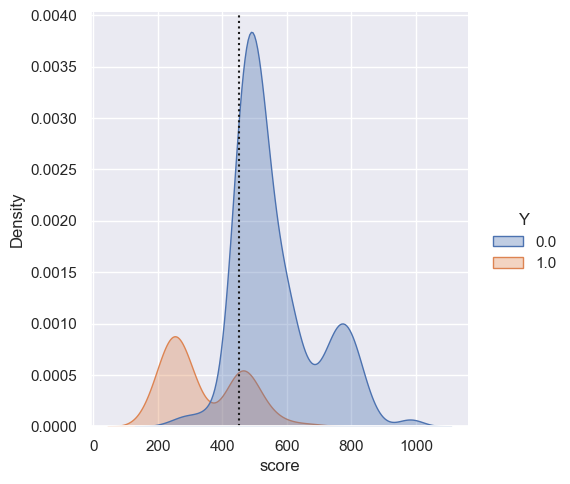

In [113]:
# Ahora representamos en un gráfico cómo separa el modelo a los buenos y los malos
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\naira\anaconda3\envs\risk1_env\Lib\site-packages\seabo

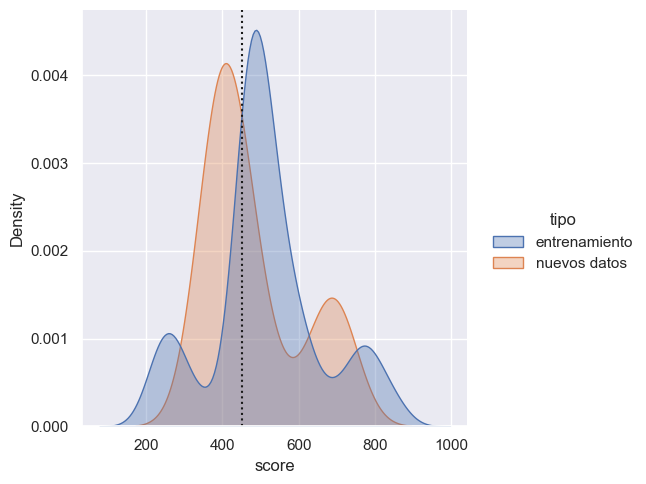

In [104]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring



# Valores nuevos
Y_nuevo = Nuevos['default'].values
X_nuevo =  Nuevos.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y


# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")



